# Automated detection and classification of malaria cells in microscopy images - Part 2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-aim" data-toc-modified-id="Introduction-and-aim-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction and aim</a></span></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#Image-augmentation" data-toc-modified-id="Image-augmentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Image augmentation</a></span></li><li><span><a href="#Convolutional-neural-network" data-toc-modified-id="Convolutional-neural-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Convolutional neural network</a></span><ul class="toc-item"><li><span><a href="#PyTorch-datasets" data-toc-modified-id="PyTorch-datasets-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PyTorch datasets</a></span></li><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Training-function" data-toc-modified-id="Training-function-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Training function</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation-on-test-set" data-toc-modified-id="Evaluation-on-test-set-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluation on test set</a></span><ul class="toc-item"><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Improvements" data-toc-modified-id="Improvements-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Improvements</a></span></li></ul></li><li><span><a href="#Pipeline:-detection-and-classification" data-toc-modified-id="Pipeline:-detection-and-classification-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Pipeline: detection and classification</a></span><ul class="toc-item"><li><span><a href="#Load-models" data-toc-modified-id="Load-models-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Load models</a></span></li><li><span><a href="#Annotate-cells" data-toc-modified-id="Annotate-cells-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Annotate cells</a></span></li><li><span><a href="#Output-diagnosis" data-toc-modified-id="Output-diagnosis-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Output diagnosis</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction and aim

In the first part of this study, I fine-tuned a pretrained Detection Tansformer (DETR) model to detect individual cells in images of blood smears taken from patients infected with *Plasmodium vivax*, the causative agent of malaria. Although the model could successfully detect cells, it was less able to distinguish between infected and uninfected cells. To overcome this, in the second part of this study, I design a custom convolutional neural network (CNN) that can classify cells according to their infection status and, if the cell is infected, further classify the cell according to the developmental stage of the parasite. And finally, I create a pipeline that takes in a blood smear image, uses DETR to detect the cells and then uses the custom CNN to determine whether or not the patient has malaria. The pipeline also outputs additional information that a healthcare practioner would take into consideration when deciding the best course of treatment for the patient.

## Import libraries

In [ ]:
# Import custom classes and functions
%run Part_1_DETR_object_detection.ipynb import DETRModel, CocoDataset   # Import classes from Part_1
import malaria_helper # custom functions and classes for data visualisation and model predictions
from malaria_helper import cells_image

In [33]:
# Import standard libraries
import numpy as np 
import pandas as pd
import json
import cv2
from PIL import Image
from imgaug import augmenters as iaa

import os
import time
from tqdm.autonotebook import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F 
import torchvision.transforms.functional as TF

from torch.utils.tensorboard import SummaryWriter
import itertools
from sklearn.metrics import confusion_matrix

pd.options.display.max_columns = 100

## Data exploration

In [7]:
with open('training.json') as f1, open('test.json') as f2:
    train = json.load(f1)
    test = json.load(f2)

train1_df = pd.read_csv('train1_df.csv')
val_df = pd.read_csv('val_df.csv')
test_df = pd.read_csv('test_df.csv')

# Data cleaning
for i in [train1_df, val_df, test_df]:
    i.columns = ['ann_id', 'image_id', 'x_min', 'y_min', 'width', 'height', 'image_width', 'image_height',
                 'pathname', 'category','category_id']
    i[['x_min', 'y_min', 'width', 'height']] = i[['x_min', 'y_min', 'width', 'height']].astype('int32')

**Visualising cell classes**

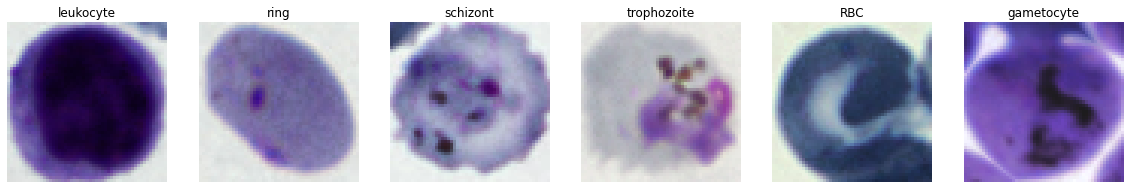

In [479]:
# Plot representative images of each class (excluding the difficult class) selected from the training dataset
malaria_helper.plot_images_dir('representative', 6,True)

As mentioned previously, there is a severe class imbalance in the dataset, with red blood cells being the most common cell type. In order to effectively train our model to correctly recognise other cell types, the number of cell images of the rarer classes can be artificially increased by adding transformations of the original images to the dataset. This is known as augmentation. Note that the `difficult` class refers to cells that could not be classified by a malaria researcher.

**Class imbalance**

In [231]:
train1_df['category'].value_counts() 

red blood cell    70264
trophozoite        1283
difficult           375
ring                327
schizont            172
gametocyte          130
leukocyte            97
Name: category, dtype: int64

Before the cells can be augmented, they first need to be extracted from the blood smear images and resized to the same dimensions, as neural networks require the inputs to be of fixed size.

In [236]:
print(f'Minimum dimensions: {train1_df.height.min()}, {train1_df.width.min()}')

Minimum dimensions: 53, 54


## Image augmentation

In [489]:
def image_augment(aug_pipeline, directory, number):
    '''
    Apply augmentations to all the images in a directory.
    '''
    for img in os.listdir(directory):
        if not img.startswith('.'):   
            cell = cv2.imread(os.path.join(directory, img)) 
            for i in range(number):
                cell_aug = aug_pipeline.augment_images([cell])[0]
                cell_name = os.path.join(directory, str(i) + '_' + img)
                cv2.imwrite(cell_name, cell_aug)
    return

An example showing what the augmented images will look like; the image on the far right is the original image before undergoing transformation. The transformations were chosen to mimic the variability seen in microscopy images.

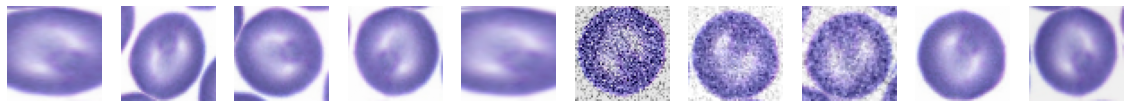

In [492]:
# Augmentation pipleine - includes flips, shears and rotations. 
aug_pipeline = iaa.SomeOf((2, 4), [
             iaa.Fliplr(1),     # flip horizontally
             iaa.Flipud(1),     # flip vertically
             iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)), 
             iaa.Affine(shear=(-30, 30),mode = 'reflect'), # shear between -20 to 20 degrees
             iaa.Affine(rotate=(-90, 90), mode = 'reflect'),
             iaa.ScaleX((0.9, 2.0), mode = 'reflect'),
             iaa.AddToBrightness((-50, 50))])

# Example of what augmented images will look like
image_augment(aug_pipeline, 'aug_test', 9)
malaria_helper.plot_images_dir('aug_test', 10, False)

Can now create training and validation datasets of images of individual cells and run them through the augmentation pipeline.

In [166]:
# Crop and resize the cells in the train and validation datasets and save to new directories.
malaria_helper.process_images(train1_df, (53,53), 'train')
malaria_helper.process_images(val_df, (53,53), 'val')

# Apply augmentation pipeline to train and validation cell images. Do not augment difficult class.
directories = ['train/trophozoite','train/ring','train/schizont','train/gametocyte', 'train/leukocyte']
numbers = [10,20,30,30,30]

for d, n in zip(directories, numbers):
    image_augment(aug_pipeline, d, n)

After augmentation, the balance between classes is improved:

In [23]:
for i in ['train/red blood cell','train/trophozoite','train/ring','train/schizont','train/gametocyte', 'train/leukocyte']:
    print(i[6:], len([name for name in os.listdir(i)]))

red blood cell 70264
trophozoite 14113
ring 6867
schizont 5332
gametocyte 4030
leukocyte 3007


## Convolutional neural network

### PyTorch datasets

In [62]:
# Create training and validation datasets
train_dataset = torchvision.datasets.ImageFolder(root = 'train', transform=ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(root = 'val', transform=ToTensor())
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

### Model architecture

For the design of the CNN, three alternating convolution and pooling layers were used. The kernel size was increased from 3X3 to 5X5 and the number of output channels increased by two-fold with each successive convolution layer. Three fully connected layers were added with the final layer containing seven output channels (one for each class).

In [27]:
# Define CNN architecture
class cell_CNN(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)  # Seven classes of cells

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training function

In [3]:
def train_fn(dataloader,model,epoch):
    model.train()        
    for i, batch in enumerate(tqdm(dataloader)):
        inputs, labels = batch
        inputs=inputs.to(device)
        labels=labels.to(device)     
        optimizer.zero_grad()
        # Make prediction
        pred = model(inputs) 
        loss = criterion(pred, labels)   
        # Backpropagation
        loss.backward()
        optimizer.step() 
        # Tensorboard log
        x = i + (epoch*6554)
        writer.add_scalar(f"Train/CEL", loss, x)
    return 

def eval_fn(dataloader, model,epoch):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            inputs, labels = batch
            inputs=inputs.to(device)
            labels=labels.to(device)
            # Make prediction
            pred = model(inputs) 
            loss = criterion(pred, labels)
            # Tensorboard log
            x = i + (epoch*467)
            writer.add_scalar(f"Val/CEL", loss, x)    
    return 

## Training

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [ ]:
writer = SummaryWriter('malaria_classify/exp_1')  

%load_ext tensorboard 
%tensorboard --logdir=malaria_classify

In [182]:
model = cell_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):
    train_fn(train_dataloader, model, epoch)
    eval_fn(val_dataloader, model, epoch)
    writer.flush()
    torch.save(model.state_dict(), f'malaria_classify_{epoch}.pth')

writer.close()

## Evaluation on test set

In [6]:
# Create test dataset
process_images(test_df, (53,53), 'test')
classify_test_dataset = torchvision.datasets.ImageFolder(root = 'test', transform=ToTensor())
classify_test_dataloader = torch.utils.data.DataLoader(classify_test_dataset, batch_size=16, shuffle=True)

In [29]:
# Load saved model
classify_model = cell_CNN().to(device)
classify_model.load_state_dict(torch.load('malaria_classify_9.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classify_model.parameters(), lr=1e-4)

In [113]:
def test_eval(dataloader):
    ground_truth = []
    predictions = []
    
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            inputs, labels = batch
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            pred = model(inputs) 
            pred = torch.argmax(pred, dim=1)
            
            ground_truth.append(labels.tolist())
            predictions.append(pred.tolist())
    return ground_truth, predictions     

### Confusion matrix

In [147]:
# Make predictions
ground_truth, predictions = test_eval(test_dataloader)

ground_truth = list(itertools.chain(*ground_truth))
predictions = list(itertools.chain(*predictions))

confusion = confusion_matrix(ground_truth, predictions, labels=[0,1,2,3,4,5,6])
confusion = confusion[1:,1:]

Plotting a confusion matrix of the ground truths versus the predictions for each class (excluding the difficult class) shows that the model is able to predict the RBC (uninfected), gametocyte, leukocyte, and trophozoite classes most accurately. Rings and schizonts are predicted with lower accuracy and are often mistaken for RBCs and gametocytes respectively. The misclassification of rings as RBCs is concerning as it could potentially lead to patients who have malaria being instead misdiagnosed as uninfected and therefore not receiving essential treatment.  

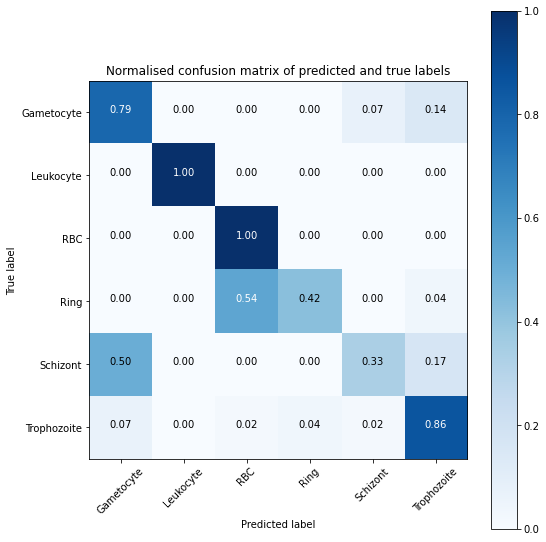

In [155]:
malaria_helper.plot_confusion_matrix(confusion, normalize=True, classes=['Gametocyte','Leukocyte','RBC','Ring',
                 'Schizont','Trophozoite'], title='Normalised confusion matrix of predicted and true labels')

### Improvements

Due to storage and memory limitations, only a limited number of augmentations could be performed on the training dataset images and so the training dataset still suffers from the issue of class imbalance. Currently, there are ten times more images of RBCs than images of rings, which may explain why the model tends to misclassify rings as RBCs. To improve the accuracy of the model, I intend to increase the number of augmented images for each class so that the dataset is balanced.  I also intend to add dropout layers to the CNN, which can help the the model generalise better. Finally, I would like to optimise the hyperparameters of the models, such as the learning rate and batch size, and experiment with using a higher momentum setting for the Adam optimiser

## Pipeline: detection and classification

### Load models

In [24]:
# Load object detection DETR model from previous example
detection_model = DETRModel(num_classes=3, num_queries=250).to(device)
detection_model.load_state_dict(torch.load('malaria_detr_1.pth'))

# Create test dataset of blood smear images using COCO annotation file
detection_test_dataset = CocoDataset(root='images', annFile = 'testcoco.json', feature_extractor = feature_extractor)

# Load custom CNN model 
classify_model = cell_CNN().to(device)
classify_model.load_state_dict(torch.load('malaria_classify_9.pth'))

Using cache found in /Users/anushkathawani/.cache/torch/hub/facebookresearch_detr_master


<All keys matched successfully>

### Annotate cells

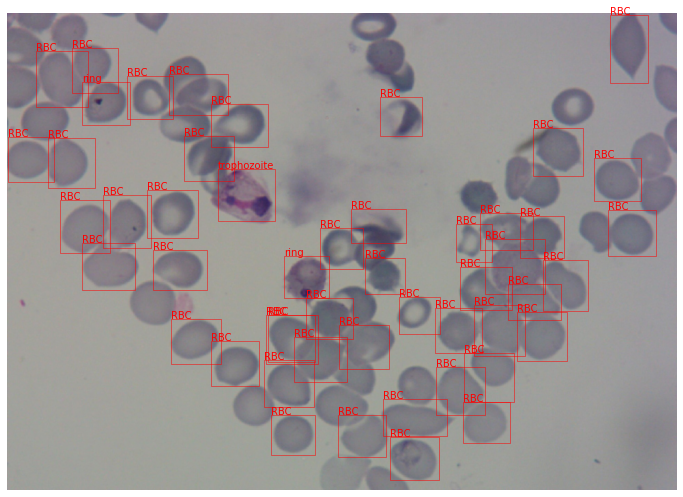

In [354]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (16,10))

cells = cells_image(number = 0, json_name = test, axis=ax)
scaled, cl = cells.detect(detection_test_dataset, detection_model) # Predict bounding boxes 
predictions = cells.classify(scaled, classify_model)
id2label = {0:'difficult', 1:'gametocyte', 2:'leukocyte', 3:'RBC', 4:'ring', 5:'schizont', 6:'trophozoite'}
    
cells.plot_cells()  # Plot blood smear image from test dataset                                 
cells.plot_pred(scaled,predictions,id2label) #Plot predicted bounding boxes (DETR) and predicted class labels (CNN)

In this case, the pipeline is able to accurately detect and classify the three infected cells in the blood smear (two rings and one trophozoite).

This pipeline can also output clinically relevant information, such as the diagnosis, the species of malarial parasite and the percentage parasitemia, which is the percentage of infected RBCs and is used to quantify the severity of the disease.

### Output diagnosis

In [84]:
malaria_helper.info(predictions)

Diagnosis: positive for malaria
Species: Plasmodium vivax
Percentage parasitemia: 7.0


## Conclusions

In the second part of this study, I created a pipeline that can detect and classify infected cells in a blood smear microscopy image and provide other, clinically relevant information that could help healthcare providers determine the best course of treatment. To perform the classification step of this pipeline, I created a convolutional neural network that classified cells with good accuracy for four out of the six classes. To improve the accuracy of the model for the ring and schizont classes, greater augmentation of the training dataset and tuning of the model's hyperparameters will be performed. Future work will involve creating a user friendly tool that will enable clinicians to upload blood smear images and receive a diagnosis. In addition, this pipeline could be further developed to detect a wider range of blood and tissue parasites that, like malaria, are traditionally diagnosed using microscopic examination.

## References

Carion, N. et al. (2020) ‘End-to-End Object Detection with Transformers’, Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 12346 LNCS, pp. 213–229. 

CDC Diagnostic Procedures - Blood Specimens. Available at: https://www.cdc.gov/dpdx/diagnosticprocedures/blood/microexam.html 

Explorer - Malaria Atlas Project. Available at: https://malariaatlas.org/explorer/#/ (Accessed: 12 September 2021).

Hung, J. et al. (2018) ‘Applying Faster R-CNN for Object Detection on Malaria Images’. 

Makanjuola, R. O. and Taylor-Robinson, A. W. (2020) ‘Improving Accuracy of Malaria Diagnosis in Underserved Rural and Remote Endemic Areas of Sub-Saharan Africa: A Call to Develop Multiplexing Rapid Diagnostic Tests’, Scientifica, 2020. 

Ogunfowokan, O., Ogunfowokan, B. A. and Nwajei, A. I. (2020) ‘Sensitivity and specificity of malaria rapid diagnostic test (mRDT CareStatTM) compared with microscopy amongst under five children attending a primary care clinic in southern Nigeria’, African Journal of Primary Health Care & Family Medicine, 12(1), pp. 1–8. 

Rogge, N. (2020) Fine tuning Detr For Object Detection on custom dataset. Available at: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR 

Rosenblatt, J. E., Reller, L. B. and Weinstein, M. P. (2009) ‘Laboratory Diagnosis of Infections Due to Blood and Tissue Parasites’, Clinical Infectious Diseases, 49(7), pp. 1103–1108. 

Singh, T. (2020) End to End Object Detection with Transformers:DETR | Kaggle. Available at: https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr 

World Health Organisation World Malaria Report 2020. Available at: https://www.who.int/teams/global-malaria-programme/reports/world-malaria-report-2020 

World Health Organization ‘Malaria surveillance , monitoring and evaluation: a reference manual’.



In [43]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")